# Batch RGB Latent Evolution: Multiple Colored Shapes with Spatial Diversity

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jtooates/blind_lm/blob/main/experiments/batch_rgb_latent_evolution.ipynb)

This notebook evolves a **batch of RGB latent images** simultaneously using InfoNCE patch coherence + spatial diversity loss.

**Purpose**: Understand how spatial diversity loss encourages different spatial patterns across the batch.

**Workflow**:
1. Configure loss weights (including spatial diversity)
2. Start with batch of random RGB noise  
3. Watch them transform into diverse colored shapes frame-by-frame

**Key differences from single-latent version**:
- Batch dimension `[B, 3, H, W]` instead of `[3, H, W]`
- Spatial diversity loss penalizes similar spatial patterns
- Visualizations show all latents in the batch

## Setup

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

print(f"PyTorch version: {torch.__version__}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

PyTorch version: 2.2.2
Using device: cpu


## Loss Functions

In [29]:
def compute_losses(latents, patch_size=3, num_samples=100, temperature=1.0,
                   positive_radius=3.0, negative_radius=11.0,
                   spatial_diversity_temperature=0.5):
    """
    Compute loss components for batch of RGB latents [B, 3, H, W].
    Returns dict of individual losses.
    
    Args:
        latents: [B, 3, H, W] tensor (batch of RGB images)
        patch_size: Size of patches for InfoNCE (default 3x3x3)
        num_samples: Number of anchor patches to sample for InfoNCE per image
        temperature: Temperature for InfoNCE similarity
        positive_radius: Max distance (pixels) for positive pairs in InfoNCE
        negative_radius: Min distance (pixels) for negative pairs in InfoNCE
        spatial_diversity_temperature: Temperature for spatial diversity loss
    """
    B, C, H, W = latents.shape
    losses = {}
    
    # 1. Magnitude: prevents collapse to near-zero values
    magnitude = torch.mean(torch.abs(latents))
    min_magnitude = 0.3
    losses['magnitude'] = torch.relu(min_magnitude - magnitude)
    
    # 2. InfoNCE RGB patch coherence (per image in batch)
    pad = patch_size // 2
    latents_padded = F.pad(latents, (pad, pad, pad, pad), mode='replicate')
    
    # Extract patches: [B, 3*patch_size^2, H*W]
    patches = F.unfold(latents_padded, kernel_size=patch_size, stride=1)
    patches = patches.permute(0, 2, 1)  # [B, H*W, 3*patch_size^2]
    
    infonce_loss = 0.0
    num_positions = H * W
    
    # Process each image in batch
    for b in range(B):
        batch_patches = patches[b]  # [H*W, 3*patch_size^2]
        
        # Sample anchor positions
        n_samples = min(num_samples, num_positions)
        anchor_indices = torch.randperm(num_positions, device=latents.device)[:n_samples]
        anchor_patches = batch_patches[anchor_indices]  # [n_samples, 3*patch_size^2]
        
        # Coordinates
        anchor_coords = torch.stack([
            anchor_indices // W,
            anchor_indices % W
        ], dim=1).float()
        
        y_coords = torch.arange(H, device=latents.device).unsqueeze(1).expand(H, W).reshape(-1)
        x_coords = torch.arange(W, device=latents.device).unsqueeze(0).expand(H, W).reshape(-1)
        all_coords = torch.stack([y_coords, x_coords], dim=1).float()
        
        for i in range(n_samples):
            anchor_patch = anchor_patches[i:i+1]
            anchor_coord = anchor_coords[i:i+1]
            
            distances = torch.norm(all_coords - anchor_coord, dim=1)
            pos_mask = (distances > 0) & (distances <= positive_radius)
            neg_mask = distances > negative_radius
            
            if pos_mask.sum() > 0 and neg_mask.sum() > 0:
                anchor_norm = F.normalize(anchor_patch, dim=1)
                patches_norm = F.normalize(batch_patches, dim=1)
                similarities = torch.matmul(anchor_norm, patches_norm.t()).squeeze(0)
                
                pos_sims = similarities[pos_mask] / temperature
                neg_sims = similarities[neg_mask] / temperature
                
                pos_exp = torch.exp(pos_sims)
                neg_exp = torch.exp(neg_sims)
                
                infonce_loss += -torch.log(pos_exp.mean() / (pos_exp.mean() + neg_exp.mean() + 1e-8))
    
    losses['coherence_infonce'] = infonce_loss / (B * max(num_samples, 1))
    
    # 3. Spatial Diversity Loss (encourages different spatial patterns)
    if B > 1:
        # Compute spatial intensity (color-agnostic): [B, H, W]
        # L2 norm across RGB channels
        spatial_intensity = latents.norm(dim=1)  # [B, H, W]
        
        # Flatten and normalize: [B, H*W]
        spatial_flat = spatial_intensity.reshape(B, -1)
        spatial_norm = F.normalize(spatial_flat, dim=1)
        
        # Compute pairwise similarity: [B, B]
        similarity = torch.mm(spatial_norm, spatial_norm.t())
        similarity = similarity / spatial_diversity_temperature
        
        # Mask diagonal
        mask = torch.eye(B, device=latents.device, dtype=torch.bool)
        similarity = similarity.masked_fill(mask, 0)
        
        # Average similarity (we want to minimize this)
        losses['spatial_diversity'] = similarity.sum() / (B * (B - 1))
    else:
        losses['spatial_diversity'] = torch.tensor(0.0, device=latents.device)
    
    return losses

print("✓ Loss functions defined")
print("\nLoss components:")
print("  magnitude:            Prevents collapse to zero")
print("  coherence_infonce:    RGB patch similarity (nearby=positive, distant=negative)")
print("  spatial_diversity:    Encourages different spatial patterns across batch")

✓ Loss functions defined

Loss components:
  magnitude:            Prevents collapse to zero
  coherence_infonce:    RGB patch similarity (nearby=positive, distant=negative)
  spatial_diversity:    Encourages different spatial patterns across batch


## 1. Configure Loss Weights and Parameters

**Adjust these to control what the images look like!**

In [30]:
# ============================================================================
# LOSS WEIGHTS - EXPERIMENT WITH THESE!
# ============================================================================

weights = {
    # Magnitude: prevents collapse to near-zero values
    'magnitude': 5.0,
    
    # InfoNCE: encourages nearby patches to be similar, distant patches to differ
    'coherence_infonce': 2.0,
    
    # Spatial diversity: encourages different spatial patterns across batch
    'spatial_diversity': 1.0,
}

# ============================================================================
# INFONCE PARAMETERS
# ============================================================================

infonce_patch_size = 3          # Patch size for InfoNCE (3x3x3 for RGB)
infonce_num_samples = 25        # Number of anchor patches per image
infonce_temperature = 1.0       # Temperature for similarity
infonce_positive_radius = 3.0   # Max distance for positive pairs
infonce_negative_radius = 11.0  # Min distance for negative pairs

# ============================================================================
# SPATIAL DIVERSITY PARAMETERS
# ============================================================================

spatial_diversity_temperature = 0.5  # Lower = stronger penalty for similar patterns

# ============================================================================
# OPTIMIZATION SETTINGS
# ============================================================================

batch_size = 4               # Number of latents to evolve simultaneously
num_steps = 250              # Total optimization steps
snapshot_interval = 25       # Save visualization every N steps
learning_rate = 0.02         # Adam learning rate
image_size = 32              # Latent is 32x32 per channel
random_seed = 42             # For reproducibility (None = random)

# ============================================================================

print("Configuration:")
print(f"  Batch size: {batch_size}")
print(f"  RGB latent size per image: [3, {image_size}, {image_size}]")
print(f"  Total batch shape: [{batch_size}, 3, {image_size}, {image_size}]")
print(f"  Total steps: {num_steps}")
print(f"  Snapshots every {snapshot_interval} steps")
print(f"  Learning rate: {learning_rate}")

print(f"\nInfoNCE parameters:")
print(f"  Patch size: {infonce_patch_size}x{infonce_patch_size}x3 (RGB)")
print(f"  Samples per image: {infonce_num_samples}")
print(f"  Temperature: {infonce_temperature}")
print(f"  Positive radius: {infonce_positive_radius} pixels")
print(f"  Negative radius: {infonce_negative_radius} pixels")

print(f"\nSpatial diversity parameters:")
print(f"  Temperature: {spatial_diversity_temperature}")
print(f"  (Lower = stronger penalty for similar spatial patterns)")

print(f"\nActive losses:")
for name, weight in weights.items():
    if weight > 0:
        print(f"  {name:30s}: {weight:.2f}")

Configuration:
  Batch size: 4
  RGB latent size per image: [3, 32, 32]
  Total batch shape: [4, 3, 32, 32]
  Total steps: 250
  Snapshots every 25 steps
  Learning rate: 0.02

InfoNCE parameters:
  Patch size: 3x3x3 (RGB)
  Samples per image: 25
  Temperature: 1.0
  Positive radius: 3.0 pixels
  Negative radius: 11.0 pixels

Spatial diversity parameters:
  Temperature: 0.5
  (Lower = stronger penalty for similar spatial patterns)

Active losses:
  magnitude                     : 5.00
  coherence_infonce             : 2.00
  spatial_diversity             : 1.00


## 2. Initialize Batch of RGB Latents

Start with Gaussian noise for each image

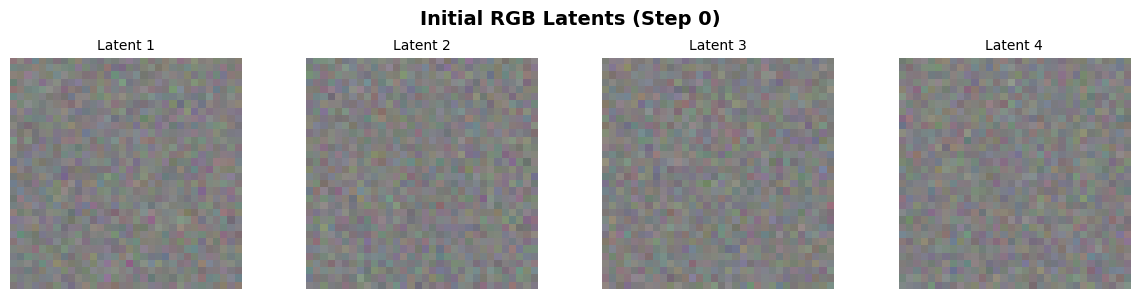

✓ Initialized latents: torch.Size([4, 3, 32, 32])
  Min value: -0.383
  Max value: 0.422
  Mean value: 0.001


In [31]:
# Set random seed if specified
if random_seed is not None:
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

# Initialize batch of RGB latents [B, 3, H, W]
latents = torch.randn(batch_size, 3, image_size, image_size) * 0.1
latents = latents.to(device)
latents.requires_grad_(True)

# Helper function to convert latent to displayable RGB
def latent_to_rgb(latent_chw):
    """Convert [3, H, W] tensor to [H, W, 3] numpy for display, normalized to [0, 1]"""
    rgb = latent_chw.detach().cpu().numpy()
    rgb = np.transpose(rgb, (1, 2, 0))  # [3, H, W] -> [H, W, 3]
    # Normalize from [-1.5, 1.5] to [0, 1]
    rgb = (rgb + 1.5) / 3.0
    rgb = np.clip(rgb, 0, 1)
    return rgb

# Visualize initial state
fig, axes = plt.subplots(1, batch_size, figsize=(3 * batch_size, 3))
if batch_size == 1:
    axes = [axes]

for i in range(batch_size):
    rgb = latent_to_rgb(latents[i])
    axes[i].imshow(rgb)
    axes[i].set_title(f'Latent {i+1}', fontsize=10)
    axes[i].axis('off')

plt.suptitle('Initial RGB Latents (Step 0)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"✓ Initialized latents: {latents.shape}")
print(f"  Min value: {latents.min().item():.3f}")
print(f"  Max value: {latents.max().item():.3f}")
print(f"  Mean value: {latents.mean().item():.3f}")

## 3. Run Optimization with Snapshots

Watch the latents evolve step by step!

In [32]:
# Reset optimizer
optimizer = torch.optim.Adam([latents], lr=learning_rate)

# Storage for snapshots
snapshots = []  # List of [B, 3, H, W] numpy arrays
snapshot_steps = []
loss_history = []
loss_components_history = {name: [] for name in weights.keys()}

# Save initial state
snapshots.append(latents.detach().cpu().numpy().copy())
snapshot_steps.append(0)

print("Starting optimization...\n")

for step in range(num_steps):
    optimizer.zero_grad()
    
    # Compute all losses
    losses = compute_losses(
        latents,
        patch_size=infonce_patch_size,
        num_samples=infonce_num_samples,
        temperature=infonce_temperature,
        positive_radius=infonce_positive_radius,
        negative_radius=infonce_negative_radius,
        spatial_diversity_temperature=spatial_diversity_temperature
    )
    
    # Build weighted total loss
    total_loss = sum(losses[name] * weights[name] for name in losses if name in weights)
    
    # Optimize
    total_loss.backward()
    optimizer.step()
    
    # Clamp to valid range
    with torch.no_grad():
        latents.clamp_(-1.5, 1.5)
    
    loss_history.append(total_loss.item())
    
    # Save snapshot
    if (step + 1) % snapshot_interval == 0:
        snapshots.append(latents.detach().cpu().numpy().copy())
        snapshot_steps.append(step + 1)
        
        # Print loss breakdown
        loss_str = f"Step {step + 1:3d}/{num_steps}: Loss = {total_loss.item():.4f}"
        component_strs = []
        for name in weights:
            if weights[name] > 0:
                component_strs.append(f"{name}={losses[name].item():.3f}")
        loss_str += " (" + ", ".join(component_strs) + ")"
        print(loss_str)

# Save final state if not already saved
if num_steps % snapshot_interval != 0:
    snapshots.append(latents.detach().cpu().numpy().copy())
    snapshot_steps.append(num_steps)

print(f"\n✓ Optimization complete!")
print(f"  Captured {len(snapshots)} snapshots")
print(f"  Final loss: {loss_history[-1]:.4f}")
print(f"  Initial loss: {loss_history[0]:.4f}")

Starting optimization...

Step  25/250: Loss = 2.3880 (magnitude=0.122, coherence_infonce=0.659, spatial_diversity=0.463)
Step  50/250: Loss = 1.7493 (magnitude=0.020, coherence_infonce=0.644, spatial_diversity=0.360)
Step  75/250: Loss = 1.5078 (magnitude=0.000, coherence_infonce=0.647, spatial_diversity=0.213)
Step 100/250: Loss = 1.3938 (magnitude=0.000, coherence_infonce=0.639, spatial_diversity=0.117)
Step 125/250: Loss = 1.3181 (magnitude=0.000, coherence_infonce=0.621, spatial_diversity=0.076)
Step 150/250: Loss = 1.3221 (magnitude=0.000, coherence_infonce=0.624, spatial_diversity=0.074)
Step 175/250: Loss = 1.2767 (magnitude=0.000, coherence_infonce=0.602, spatial_diversity=0.072)
Step 200/250: Loss = 1.2754 (magnitude=0.000, coherence_infonce=0.604, spatial_diversity=0.068)
Step 225/250: Loss = 1.2842 (magnitude=0.000, coherence_infonce=0.610, spatial_diversity=0.065)
Step 250/250: Loss = 1.2662 (magnitude=0.000, coherence_infonce=0.598, spatial_diversity=0.070)

✓ Optimizatio

## 4. Visualize Evolution

See all snapshots for all latents

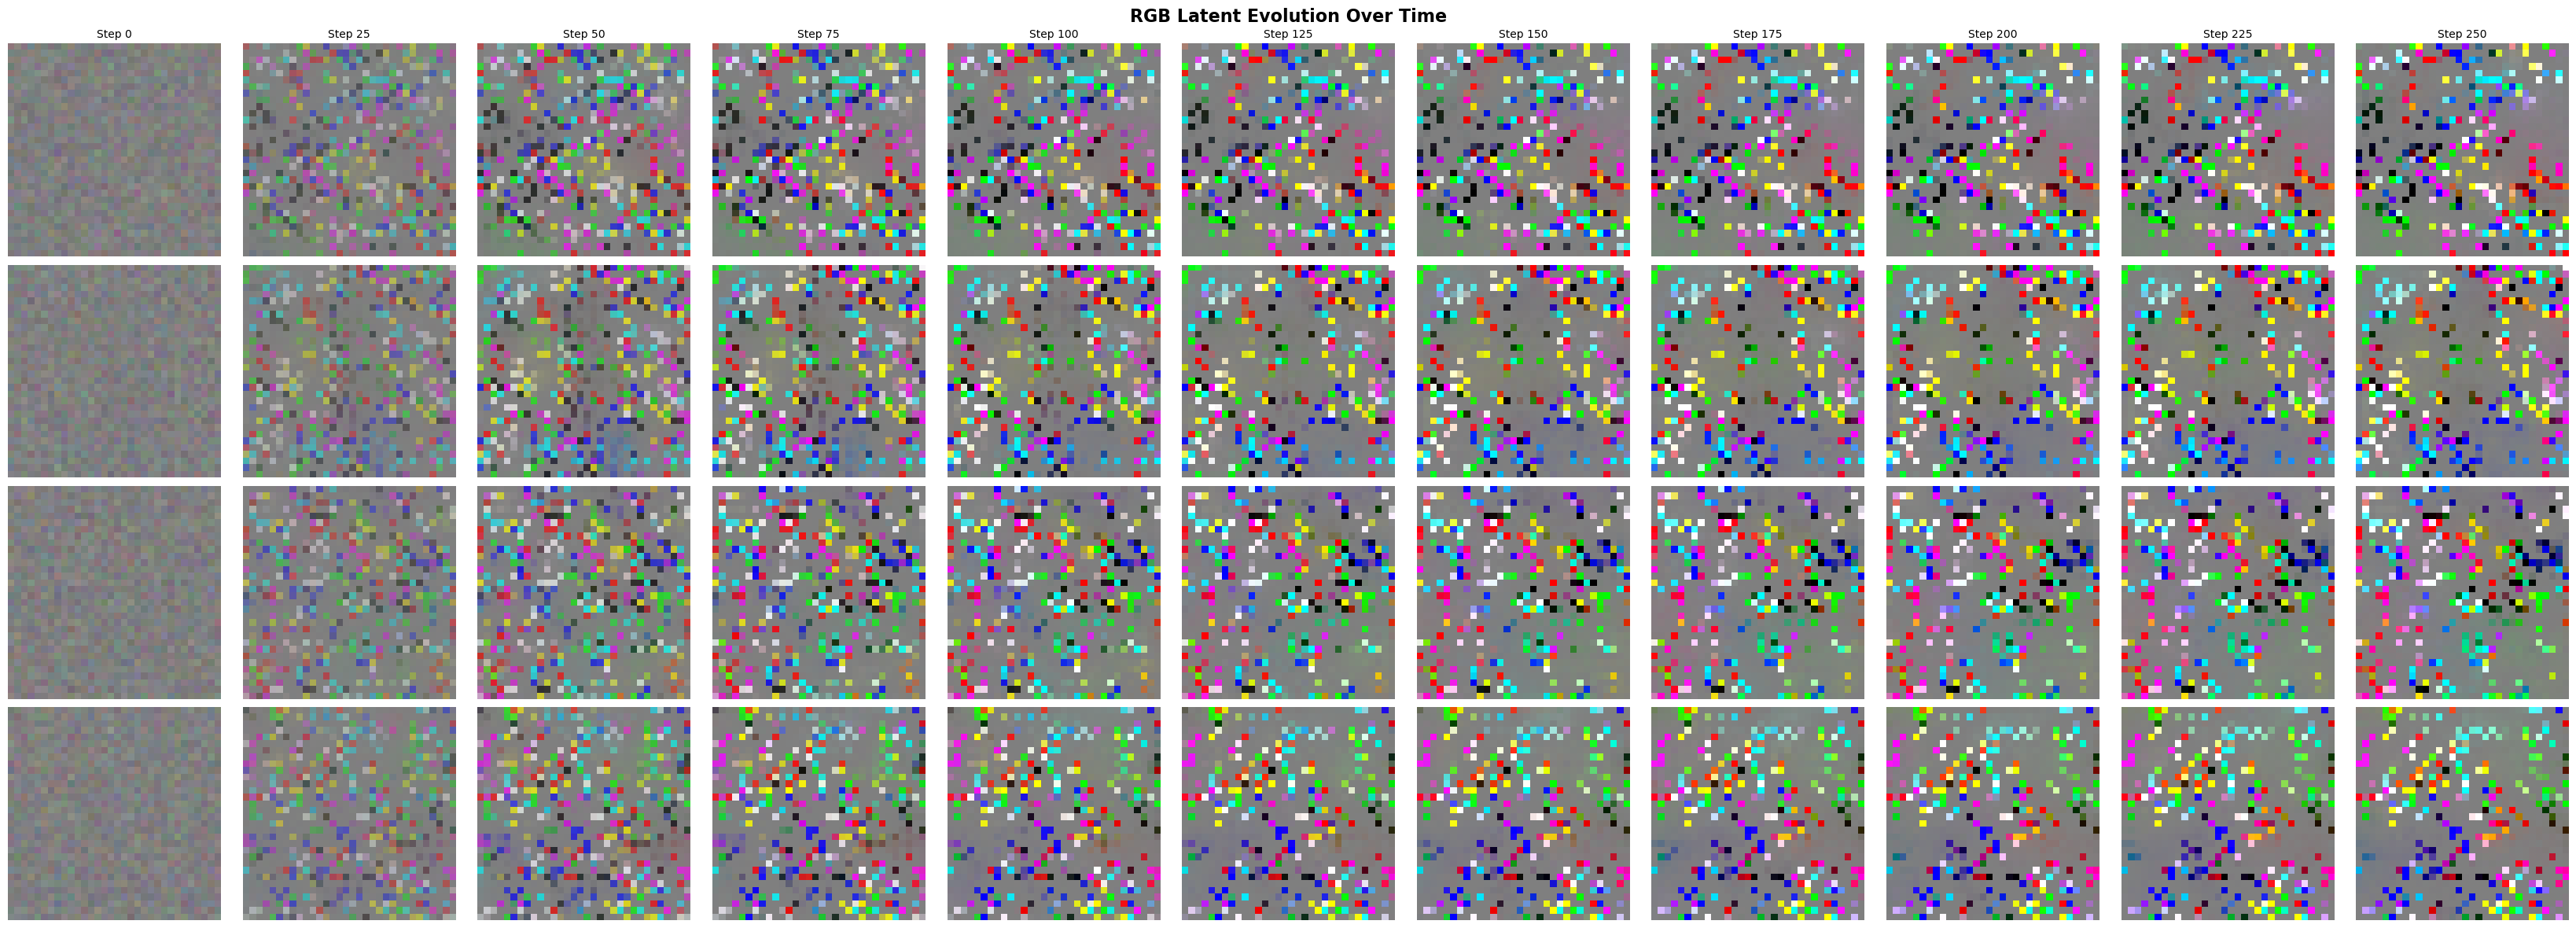


Evolution summary:
  4 latents evolved from step 0 → 250
  Look for diverse spatial patterns across the rows!


In [33]:
# Show evolution of each latent over time
num_snapshots = len(snapshots)

fig, axes = plt.subplots(batch_size, num_snapshots, figsize=(3 * num_snapshots, 3 * batch_size))
if batch_size == 1:
    axes = axes.reshape(1, -1)
if num_snapshots == 1:
    axes = axes.reshape(-1, 1)

for b in range(batch_size):
    for s, (snapshot, step) in enumerate(zip(snapshots, snapshot_steps)):
        ax = axes[b, s]
        rgb = latent_to_rgb(torch.tensor(snapshot[b]))
        ax.imshow(rgb)
        if b == 0:
            ax.set_title(f'Step {step}', fontsize=10)
        if s == 0:
            ax.set_ylabel(f'Latent {b+1}', fontsize=10, rotation=0, labelpad=30)
        ax.axis('off')

plt.suptitle('RGB Latent Evolution Over Time', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nEvolution summary:")
print(f"  {batch_size} latents evolved from step {snapshot_steps[0]} → {snapshot_steps[-1]}")
print(f"  Look for diverse spatial patterns across the rows!")

## 5. Side-by-Side Comparison

Initial vs Final for all latents

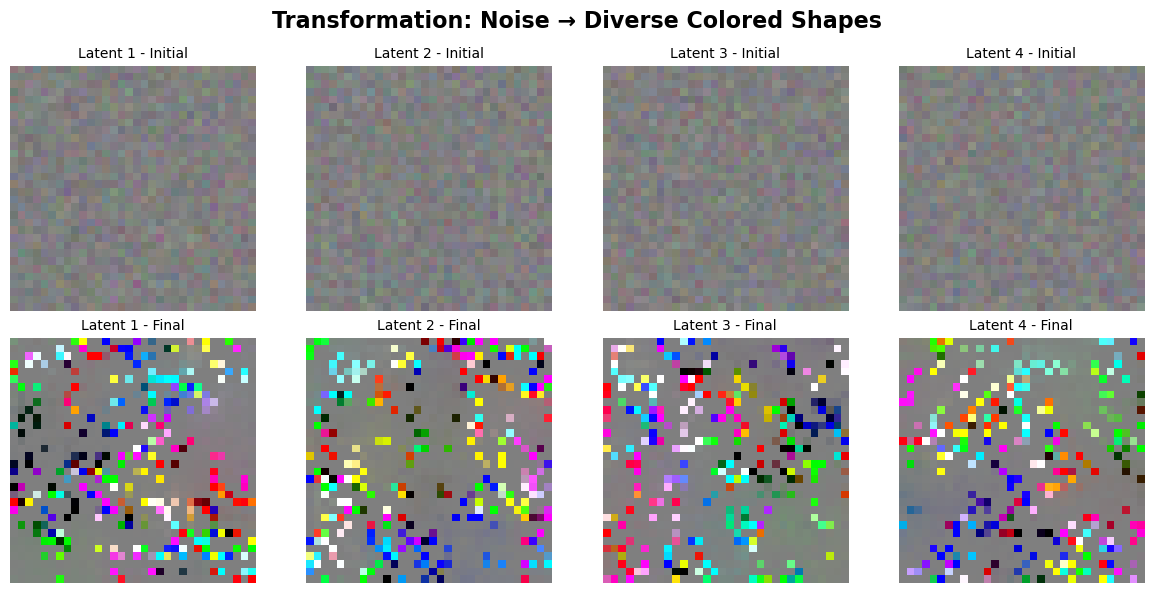


Notice how each latent developed a different spatial pattern!
This is the effect of the spatial diversity loss.


In [34]:
fig, axes = plt.subplots(2, batch_size, figsize=(3 * batch_size, 6))
if batch_size == 1:
    axes = axes.reshape(-1, 1)

# Initial (top row)
for i in range(batch_size):
    rgb = latent_to_rgb(torch.tensor(snapshots[0][i]))
    axes[0, i].imshow(rgb)
    axes[0, i].set_title(f'Latent {i+1} - Initial', fontsize=10)
    axes[0, i].axis('off')

# Final (bottom row)
for i in range(batch_size):
    rgb = latent_to_rgb(torch.tensor(snapshots[-1][i]))
    axes[1, i].imshow(rgb)
    axes[1, i].set_title(f'Latent {i+1} - Final', fontsize=10)
    axes[1, i].axis('off')

plt.suptitle('Transformation: Noise → Diverse Colored Shapes', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nNotice how each latent developed a different spatial pattern!")
print("This is the effect of the spatial diversity loss.")

## 6. Plot Loss Curves

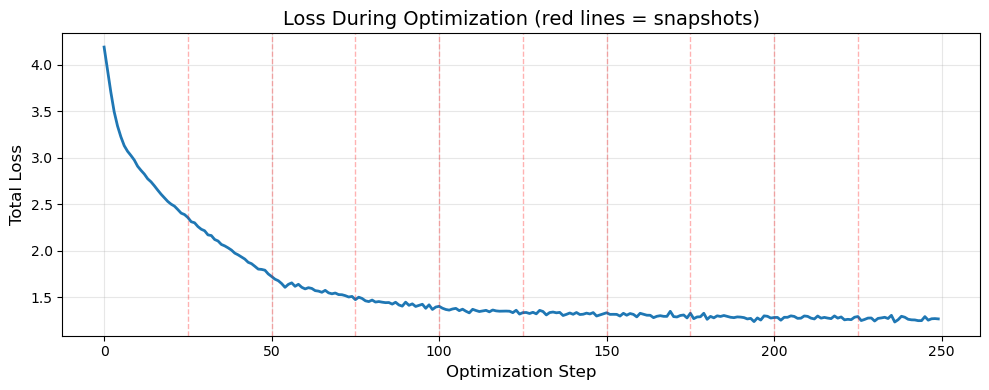

Loss reduction: 69.8%


In [35]:
plt.figure(figsize=(10, 4))
plt.plot(loss_history, linewidth=2)

# Mark snapshot points
for step in snapshot_steps[1:]:
    if step < len(loss_history):
        plt.axvline(x=step, color='red', alpha=0.3, linestyle='--', linewidth=1)

plt.xlabel('Optimization Step', fontsize=12)
plt.ylabel('Total Loss', fontsize=12)
plt.title('Loss During Optimization (red lines = snapshots)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Loss reduction: {(loss_history[0] - loss_history[-1]) / abs(loss_history[0]) * 100:.1f}%")

## 7. Compute Spatial Diversity Metric

Measure how different the spatial patterns are over time

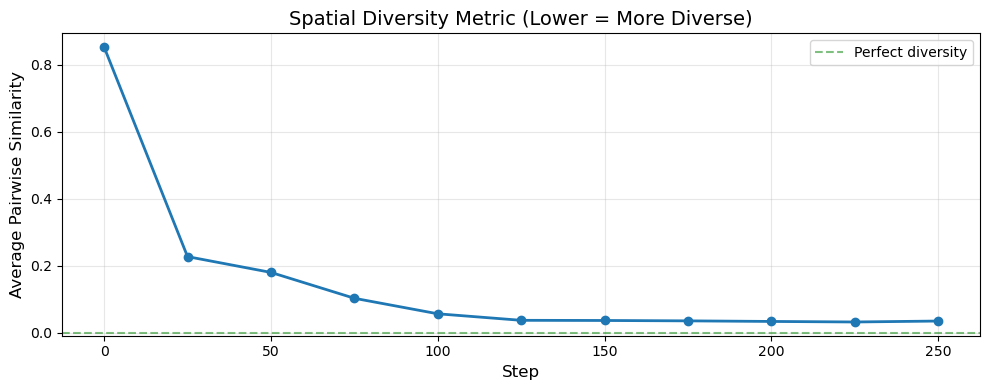

Initial similarity: 0.8523
Final similarity: 0.0351
Change: -0.8172

Lower values = more diverse spatial patterns
Negative values = patterns are pointing in opposite directions!


In [36]:
def compute_pairwise_similarity(latents_bchw):
    """Compute average pairwise spatial similarity for a batch"""
    B = latents_bchw.shape[0]
    if B <= 1:
        return 0.0
    
    # Compute spatial intensity (L2 norm across RGB)
    spatial_intensity = torch.norm(latents_bchw, dim=1)  # [B, H, W]
    spatial_flat = spatial_intensity.reshape(B, -1)  # [B, H*W]
    spatial_norm = F.normalize(spatial_flat, dim=1)
    
    # Pairwise cosine similarity
    similarity = torch.mm(spatial_norm, spatial_norm.t())
    
    # Mask diagonal and average
    mask = torch.eye(B, device=latents_bchw.device, dtype=torch.bool)
    similarity = similarity.masked_fill(mask, 0)
    
    return similarity.sum().item() / (B * (B - 1))

# Compute diversity metric for each snapshot
diversity_scores = []
for snapshot in snapshots:
    snapshot_tensor = torch.tensor(snapshot, dtype=torch.float32)
    score = compute_pairwise_similarity(snapshot_tensor)
    diversity_scores.append(score)

# Plot diversity over time
plt.figure(figsize=(10, 4))
plt.plot(snapshot_steps, diversity_scores, linewidth=2, marker='o', markersize=6)
plt.axhline(y=0, color='green', linestyle='--', alpha=0.5, label='Perfect diversity')
plt.xlabel('Step', fontsize=12)
plt.ylabel('Average Pairwise Similarity', fontsize=12)
plt.title('Spatial Diversity Metric (Lower = More Diverse)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Initial similarity: {diversity_scores[0]:.4f}")
print(f"Final similarity: {diversity_scores[-1]:.4f}")
print(f"Change: {diversity_scores[-1] - diversity_scores[0]:.4f}")
print(f"\nLower values = more diverse spatial patterns")
print(f"Negative values = patterns are pointing in opposite directions!")

## Experiments to Try

Go back to the "Configure Loss Weights and Parameters" cell and try:

### 1. No Spatial Diversity (Baseline)
```python
weights = {
    'magnitude': 5.0,
    'coherence_infonce': 2.0,
    'spatial_diversity': 0.0,  # DISABLED
}
```
**Expected**: All latents will likely converge to similar patterns (same blob location)

### 2. Strong Spatial Diversity
```python
weights = {
    'magnitude': 5.0,
    'coherence_infonce': 2.0,
    'spatial_diversity': 5.0,  # VERY STRONG
}
spatial_diversity_temperature = 0.05  # Very aggressive
```
**Expected**: Very different spatial patterns (blobs in different locations/shapes)

### 3. Only Spatial Diversity (No Coherence)
```python
weights = {
    'magnitude': 5.0,
    'coherence_infonce': 0.0,  # DISABLED
    'spatial_diversity': 2.0,
}
```
**Expected**: Diverse patterns but potentially noisy (no smoothness constraint)

### 4. Vary Batch Size
Try `batch_size = 2` vs `batch_size = 8` to see how many latents affect diversity pressure

### 5. Vary Temperature
Compare:
- `spatial_diversity_temperature = 0.05` (very aggressive)
- `spatial_diversity_temperature = 0.1` (aggressive)
- `spatial_diversity_temperature = 0.5` (moderate)
- `spatial_diversity_temperature = 1.0` (gentle)

### 6. Adjust InfoNCE Radii
**Tighter coherence** (smaller regions):
```python
infonce_positive_radius = 2.0
infonce_negative_radius = 8.0
```

**Broader coherence** (larger regions):
```python
infonce_positive_radius = 5.0
infonce_negative_radius = 15.0
```